#  Long Short-Term Memory model for lokal temperature predictions
## By Eva Bendix Nielsen,
## For master thesis: Predicting climate with Machine learning


In this study a Long Short-Term Memory (LSTM) model is used to predict the annual winter local temperature for Europe given the global value of total solar irradiance, carbon dioxide and the volcaninc areosol. 

Keras is used for building the model. 

In [1]:
import keras.layers 
import keras.models
from pandas import read_csv
import numpy as np
from keras.models import Sequential
from keras.layers import Input, Dense, Activation, LSTM
from keras.optimizers import Adam 
from matplotlib import pyplot
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from math import sqrt

Using TensorFlow backend.


Before loading the dataset some values needs to be defined. This includes the batch size, the epoch and much more.

In [2]:
location = 3                        # Choose the location for prediction 
batch_s = 10                        # The batch size since it is a statefull LSTM it is equal to the input size 
year_end = 500                      # The amount of year for training 
year_end_shifted = year_end +1      # The last year for a shifted model
test_train_split = 460              # The years for trining
training_epoch = 10                 # The amount of training epochs 

Then the data is loaded. The file DATA_DK_1500_2000_DK_GB.csv contains the values for the three cllimate drivers. The file 'DATA_EUROPE_1500_2000.csv' contains the winter tempersature for 11 locations in Eurpoe. The data are divided into a test and training set before scaling to hinder bias in the test set. The temperature is made into two dataset one from 1500 to 1999 and one from 1501 to 2000. This is nedded since the output is the temperture the following year hence a temperature shifted one year ahead. 

In [3]:
# Loading data and parameters
dataset = read_csv('DATA_DK_1500_2000_DK_GB.csv', header=None, index_col=0)
values = dataset.values
values = np.flip(values,0) 

# Loading the temperature
dataset1 = read_csv('DATA_EUROPE_1500_2000.csv', header=None, index_col=0)
values1 = dataset1.values

# #Dividing temperature into test and train for both shifted and non shifted
T_train = values1[0:test_train_split, location:location+1]
T_test = values1[test_train_split:year_end,location:location+1]

T_train_shifted= values1[1:test_train_split+1,location:location+1]
T_test_shifted= values1[test_train_split+1:year_end_shifted,location:location+1]


# Dividing climate driver into test and train for both shifted and non shifted
P_train = values[1:test_train_split+1,0:3]
P_test = values[test_train_split+1:year_end_shifted,0:3]


print('Dimensions of training set:')
print(T_train.shape)
print('And of test set: ')
print(T_test.shape)


Dimensions of training set:
(460, 1)
And of test set: 
(40, 1)


The  next step is to scale the temperature, shifted temperature and climate drivers individual to a value between 0 and 1 using MinMaxScaler fron Scikit-learn.

In [4]:
# Scaling tempperature
scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(T_train)
T_train_scaled = scaler.transform(T_train)
T_test_scaled = scaler.transform(T_test)


# Scaling shifted tempperature
scaler1 = MinMaxScaler(feature_range=(0, 1))
scaler1 = scaler1.fit(T_train_shifted)
T_train_shifted_scaled = scaler1.transform(T_train_shifted)
T_test_shifted_scaled = scaler1.transform(T_test_shifted)

# Scaling climate drivers
scaler2 = MinMaxScaler(feature_range=(0, 1))
scaler2 = scaler2.fit(P_train)
P_train_scaled = scaler2.transform(P_train)
P_test_scaled = scaler2.transform(P_test)


## Shaping the input 
The input in the LSTM model is a 3D tensor with the shape: (samples, batch, channels). Channels is the number of features where temperature for instant is one feature. The next step is therefore to shape the training and test set into this dimension and creating a sliding window for more batches to train on. The shifted temperature needs to have the same amount of batches for the model to know the right result. This is therefore also defined.

In [5]:
# Setting the climate drivers and the non-shifted temperature in the same matrix to use as input
TP_train = np.hstack((P_train_scaled,T_train_scaled))
TP_test = np.hstack((P_test_scaled, T_test_scaled))

# Creating a sliding window
Shift=5                        # how big an overlap in batch

Batch_n = (test_train_split-batch_s)//Shift    # Number of new batches

# Creating an empty tensor to fill with the new batches
TP_train_B = np.zeros((Batch_n, batch_s, 4))         # B is for batch
TT_train_shifted_B = np.zeros((Batch_n,batch_s, 1))
   
# Defining the new batches and inserting them in the tensor 
for i in range(Batch_n): 
    g = i*Shift
    TP_train_B[i,:,:] = TP_train[g:g+batch_s,:]                         # For climate drivers and temperature 
    TT_train_shifted_B [i,:,:] = T_train_shifted_scaled[g:g+batch_s,:]  # For shifted temperature 
    
    
print('Dimensions of training input:')
print(TP_train_B.shape)
print('And dimension of temperature for trainin the model (shifted temperature): ')
print(TT_train_shifted_B.shape)

Dimensions of training input:
(90, 10, 4)
And dimension of temperature for trainin the model (shifted temperature): 
(90, 10, 1)


The correct tensors are now created for training the model. The trianing have 4 channels which is the 3 climate drivers and the temperature for the previous years which can be defined as x. The shifted temperature have one channel which is the temperature for the year the model shall predict, which can be defined as y. The next step is to create a model that makes the mapping f(x)=y.

## Defining the architecture 

The architecture now needs to be defined and it is structured as shown in the table below.
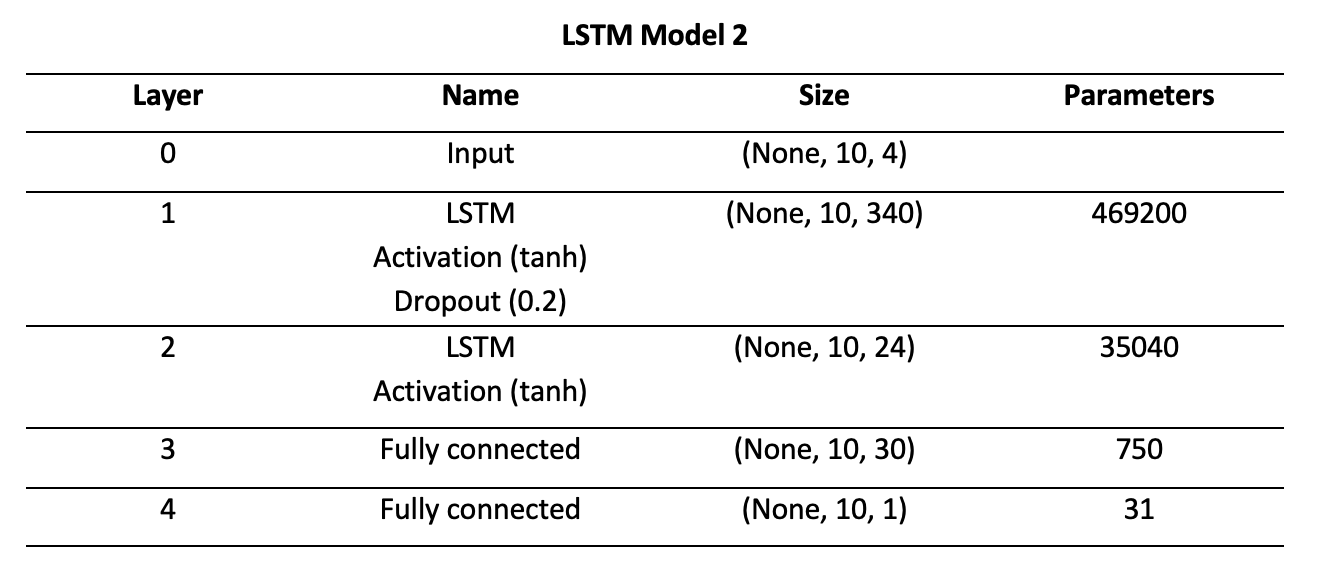

In [6]:
input_s = (10,4)    # The input shape 

model = Sequential()
model.add(LSTM(340, input_shape=input_s, return_sequences=True, dropout=0.2)) 
model.add(LSTM(24, return_sequences=True)) 
model.add(Dense(30))
model.add(Dense(1))

adam = Adam(lr=0.000001) # Defining the learning rate 

model.compile(loss='mse', optimizer=adam, metrics=['mean_squared_error'])

The next step is to train the model using the previusly defined inputs. Almost 10 years is removed from the trainig input for validating the model. This step may take a while for faster but worse lerning set number on epoch lower. 


In [7]:
# defining validation set
Val_batch=Batch_n-(10//Shift)

x_val = TP_train_B[Val_batch:, ::, ::]
y_val = TT_train_shifted_B[Val_batch:, ::, ::]

# removing validation from trainingset 
x_train = TP_train_B[:Val_batch, ::, ::]
y_train = TT_train_shifted_B[:Val_batch, ::, ::]



# Training the model
history = model.fit(x_train,y_train , validation_data=(x_val,y_val) , batch_size=batch_s, epochs=training_epoch, shuffle=False) 

Train on 88 samples, validate on 2 samples
Epoch 1/10
88/88 [==============================] - 2s 18ms/step - loss: 0.3279 - mean_squared_error: 0.3279 - val_loss: 0.3798 - val_mean_squared_error: 0.3798
Epoch 2/10
88/88 [==============================] - 0s 2ms/step - loss: 0.3269 - mean_squared_error: 0.3269 - val_loss: 0.3786 - val_mean_squared_error: 0.3786
Epoch 3/10
88/88 [==============================] - 0s 2ms/step - loss: 0.3257 - mean_squared_error: 0.3257 - val_loss: 0.3774 - val_mean_squared_error: 0.3774
Epoch 4/10
88/88 [==============================] - 0s 2ms/step - loss: 0.3281 - mean_squared_error: 0.3281 - val_loss: 0.3762 - val_mean_squared_error: 0.3762
Epoch 5/10
88/88 [==============================] - 0s 2ms/step - loss: 0.3243 - mean_squared_error: 0.3243 - val_loss: 0.3750 - val_mean_squared_error: 0.3750
Epoch 6/10
88/88 [==============================] - 0s 2ms/step - loss: 0.3238 - mean_squared_error: 0.3238 - val_loss: 0.3738 - val_mean_squared_error: 0.3

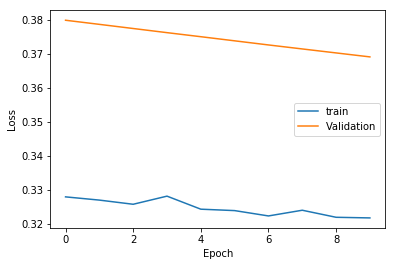

In [9]:
pyplot.figure()
pyplot.plot(history.history['loss'])
pyplot.plot(history.history['val_loss'])
pyplot.ylabel('Loss')
pyplot.xlabel('Epoch')
pyplot.legend(['train', 'Validation'])
pyplot.show()

Now the model have trained and the loss function and the accuracy for the training and validation set is graphed above.

# Predicting and plotting temperatures 
Since the model has trained a prediction can be made on the test set. The next  illustartes the way of predicting the temperature described as LSTM model 2 were the correct temperatures is provided for the first 10 years and then it is predicting based on its own predictions. 

In [22]:
which = 0
Prior = 10                   # Gives the 10 years for the model to predict on 
TP_test_2 = TP_test
track = TP_test_2[:Prior, :] # 


for j in range(30):                                   # Setting the number of years for prediction
    new_temp = model.predict(track[np.newaxis,:,:])   # Making 1 year of prediction
    new = new_temp[::, -1, ::]                        
    TP_test_2[10+j,3:] = new                          # placing the new predicted temperatures after the previous 
    track = TP_test_2[1+j:11+j, ::]                   # Updating the next input to the model for prediction 
    

Now the 30 years of temperature has been predicted. The next step is to scale it back.

In [23]:
y_predict = TP_test_2[:40,:]            # Defining the predicted values 

predict_sc=scaler.inverse_transform(y_predict)    # Scale back to temperature 

T_predict_sc = predict_sc[:,3:]     # Defining the temperature 

The predicted temperature are now rescaled and the values can be plotted.

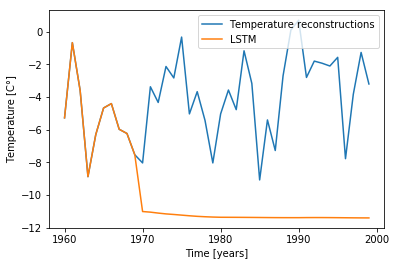

In [24]:
my_xticks = [ 1960, 1970, 1980, 1990, 2000]

x= [0, 10, 20, 30, 40]


pyplot.figure()
pyplot.plot(T_test[:batch_s+30,0], label='Temperature reconstructions')
pyplot.plot(T_predict_sc[:30+batch_s], label='LSTM')
pyplot.legend()
pyplot.ylabel("Temperature [C°]")
pyplot.xlabel("Time [years]")
pyplot.xticks(x, my_xticks)
pyplot.show()